In [1]:
from Functions import *
import winsound

# Preliminary

In [2]:
def define_beamline_normal(
    E0, m1_p=185.0, m1_q=-25.6, m2_p=141.6, m2_q=1e5,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 0.0,
    hkl2 = [2,2,0], alphaAsym2 = 0.0,
    hkl3 = [5,5,5], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=512)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m1_q=m1_q, m2_p=m2_p, m2_q=m2_q)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
                            hkl=hkl3, alphaAsym=alphaAsym3,
                            shapeErrors=shapeErrors,
                            l_crystal=l_crystal,
                            w_crystal=w_crystal)

    all_devices = [im_input] + Telescope_devices + HHLM_devices + HRM_devices
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline

### 1. common simulation parameters

In [3]:
##### ''' Beam parameters '''
N = 1024          # number of sampling points
E0 = 9000        # photon energy [eV]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 650
}

##### common simulation parameters
m1_p = 185.0     # mirror 1 source distance

# calculate beam size at mirror 1
wavelength = 1239.84193e-9/E0
Rayleigh_length = np.pi*beam_params['sigma_x']**2/wavelength
beam_width_z = 2.35*beam_params['sigma_x'] * np.sqrt(1+np.square((m1_p)/Rayleigh_length))    # 2 x FWHM

# estimate m2_p geometrically
beam_size_factor = 0.8
m2_p = 2.65e-3*beam_size_factor/(2.65e-3*beam_size_factor-beam_width_z)*115
m1_q = 115.0 - m2_p

# m2_p = 167.84807898562158    # optimzied 9keV-111-440
# m2_p = 167.8475572450024    # optimized 9keV-440-553
# m2_p = 154.0319268917302    # optimized 11keV
m2_p = 189.53436487067424    # optimized 9keV-111-440 80% size

print(m1_p, m1_q, m2_p)

f1 = 10.0; f2 = 10.0            # f1: crystal-mirror distance, f2: mirror focal distance

HHLM_type = '2DCM'              # 2DCM or Zigzag
HHLM_offset=20e-3
pair_distance=200e-3
hkl1 = [1,1,1]; alphaAsym1 = 9    # asymmetry angle for the 1st pair of HHLM crystal
hkl2 = [4,4,0]; alphaAsym2 = 38.3   # ````````````````````````2nd pair of HHLM crystal
hkl3 = [4,4,0]; alphaAsym3 = 15.0   # ````````````````````````2nd and 3rd HRM crystal

# list of crystals
crystals = np.array(['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4', 'C1', 'C2']); n_crys = len(crystals)

##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_plot = dir_out+'{}eV_{}_{}-{}_{}-{}_{}mm/'.format(E0, HHLM_type,
                                          hkl1[0]*100+hkl1[1]*10+hkl1[2], alphaAsym1,
                                          hkl2[0]*100+hkl2[1]*10+hkl2[2], alphaAsym2,
                                          HHLM_offset*1e3); make_dir(dir_plot)
print('\nCWD:',dir_plot)

185.0 -74.08444834069877 189.53436487067424
path exists
path exists

CWD: output/9000eV_2DCM_111-9_440-38.3_20.0mm/


### 2. calculate crystal dimensions and slit width

In [4]:
%%capture capt

# simulation parameters for the normal condition
slit_width = 1e-1
shapeErrors = [None for i in range(6)]
l_crystal = [1e-1 for i in range(6)]
w_crystal = [5e-3 for i in range(6)]

mono_devices_calc, mono_beamline_calc = define_beamline_normal(E0,
                               m1_p=m1_p, m1_q=m1_q, m2_p=m2_p,
                               HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=[None for i in range(6)],
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

b1_calc = beam.Beam(beam_params=beam_params)
b2_calc = mono_beamline_calc.propagate_beamline(b1_calc)

In [5]:
# get crytal properties
beta0s = []; braggs = []; asyms = []; OE_z = []
for device in mono_devices_calc:
    if device.name in crystals:
        beta0s.append(device.beta0)
        braggs.append(np.rad2deg(device.bragg))
        asyms.append(np.rad2deg(device.alphaAsym))
        OE_z.append(device.z)

# calculate beam FWHM after each crystal
wx1, wy1 = mono_beamline_calc.im_after_HHLM1.beam_analysis(mono_beamline_calc.im_after_HHLM1.get_profile_x(), mono_beamline_calc.im_after_HHLM1.get_profile_y())[2:4]
wx2, wy2 = mono_beamline_calc.im_after_HHLM2.beam_analysis(mono_beamline_calc.im_after_HHLM2.get_profile_x(), mono_beamline_calc.im_after_HHLM2.get_profile_y())[2:4]
wx3, wy3 = mono_beamline_calc.im_after_HHLM3.beam_analysis(mono_beamline_calc.im_after_HHLM3.get_profile_x(), mono_beamline_calc.im_after_HHLM3.get_profile_y())[2:4]
wx4, wy4 = mono_beamline_calc.im_after_HHLM4.beam_analysis(mono_beamline_calc.im_after_HHLM4.get_profile_x(), mono_beamline_calc.im_after_HHLM4.get_profile_y())[2:4]
wx5, wy5 = mono_beamline_calc.im_after_C1.beam_analysis(mono_beamline_calc.im_after_C1.get_profile_x(), mono_beamline_calc.im_after_C1.get_profile_y())[2:4]
wx6, wy6 = mono_beamline_calc.im_after_C2.beam_analysis(mono_beamline_calc.im_after_C2.get_profile_x(), mono_beamline_calc.im_after_C2.get_profile_y())[2:4]
beam_size = np.array([wx1, wx2, wx3, wx4, wx5, wx6])    # FWHM

# crystal lengths (long) and widths (short) [m]
l_crystal = np.divide(beam_size*2, np.sin(beta0s))
w_crystal = np.array([wy1, wy2, wy3, wy4, wy5, wy6])*2

print('bragg angle: {}'.format(np.round(braggs,3)))
print('asymmetry: {}'.format(np.round(asyms,3)))
print('beam size: {} mm'.format(np.round(beam_size*1e3, 3)))
print('footprint: {} mm'.format(np.round(l_crystal*1e3, 3)))
print('position: {} m\n'.format(np.round(OE_z, 5)))


# calculate slit width
slit_width = calc_slit_width(wx6*2, b2_calc.lambda0, mono_beamline_calc.mir1.q)
print('calculated slit width: {}um'.format(round(slit_width*1e6,2)))

if slit_width < 3e-6: slit_width = 3e-6
print('actual slit width: {}um\n'.format(round(slit_width*1e6,2)))

bragg angle: [12.696 12.691 45.849 45.847 45.847 45.847]
asymmetry: [ -9.    9.  -38.3  38.3   0.   15. ]
beam size: [6.092 1.063 8.049 1.065 1.065 0.625] mm
footprint: [32.965 32.964 16.182 16.182  2.968  2.439] mm
position: [955.      955.04214 955.24214 955.24154 960.      959.99941] m

calculated slit width: 1.03um
actual slit width: 3.0um



### 3. load shapeErrors (1x, old profile)

100%_shapeError_29.94W_0.0W_0.0W_0.0W_0.0W_0.0W
(5637, 2)


c:\users\nanw0\anaconda3\envs\lcls\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


-992.6758802639999 -24620.0


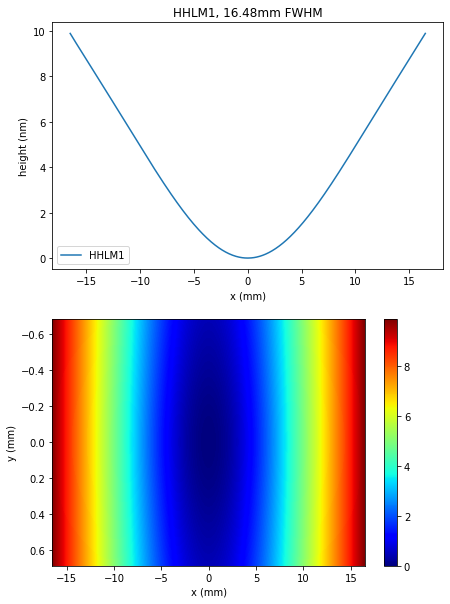

In [6]:
power_percentage = 100
if_pad = 0

crystal_powers = np.array([29.9399, 0.8317, 13.1927, 0.2418, 0.0886, 0.2848])*power_percentage/100    # crystal power for 9keV 2DCM-111-440 SASE
# crystal_powers = np.array([2.2500, 2.1438, 20.5931, 5.4141, 2.4490, 2.3313])*power_percentage/100    # crystal power for 9keV 2DCM-440-553 self-seeding
# crystal_powers = np.array([32.5683, 0.6278, 10.1661, 0.2553, 0.4179, 0.5307])*power_percentage/100    # crytal power for 11keV 2DCM-111-440 SASE

crystal_powers *= np.array([1,0,0,0,0,0])

# directories
dir_profile = '../DXS_Xtals_FEA4WFS/{}/'.format(HHLM_type)

# get file name based on crystal powers
fname_error = '{}%_shapeError'.format(power_percentage)
for i in range(n_crys):
    fname_error += '_{}W'.format(round(crystal_powers[i],3))
print(fname_error)

# holders
shapeErrors = [None for i in range(n_crys)]
x_mirs      = [None for i in range(n_crys)]
y_mirs      = [None for i in range(n_crys)]

if HHLM_type == 'Zigzag':
    crystal_profile_powers = np.array([
        [73.15, 16.53, 0.029, 0.027, 0.026, 0.03],
        [73.15, 16.79, 0.015, 0.015, 0.014, 0.013],
        [4.51, 50.1, 1.78, 1.69, 1.61, 1.88]
    ])
elif HHLM_type == '2DCM':
    crystal_profile_powers = np.array([
        [73.15, 0.027, 16.53, 0.029, 0.026, 0.03],
        [73.15, 0.015, 16.79, 0.015, 0.014, 0.013],
        [4.51, 1.69, 50.1, 1.78, 1.61, 1.88]
    ])

# choose shapeError profiles with the closest power
ratio_power = crystal_profile_powers/np.stack([crystal_powers for i in range(3)])
ratio_power[ratio_power<1] = 1/(ratio_power[ratio_power<1])
options = ratio_power.argmin(axis=0)+1

# load
for i, crystal in enumerate(crystals):
    if crystal_powers[i] == 0: continue
    # load profiles from file
    dy, xx, zz = load_crystal_data(dir_profile, crystal, options[i])
    # proportionality constant due to power and crystal dimension
    height_factor1 = crystal_powers[i] / crystal_profile_powers[options[i]-1, i]    
    height_factor2 = (l_crystal[i]*1e3/(xx.max()-xx.min()))*(w_crystal[i]*1e3/(zz.max()-zz.min()))
    shapeErrors[i] = dy*1e6 * height_factor1 / height_factor2    # [nm]
    nx, ny = shapeErrors[i].shape; end_val = shapeErrors[i].max()
    if if_pad == 1:
        # stretch in both directions
        shapeErrors[i] = np.pad(shapeErrors[i],
                                pad_width=((nx,nx),(ny,ny)), mode='linear_ramp',
                                end_values = ((end_val,end_val),(end_val,end_val)))
        # modify dimensions for the new profile
        l_crystal[i] *= 3; w_crystal[i] *= 3
        # new crytal axis
        x_mirs[i] = np.linspace(-l_crystal[i]/2, l_crystal[i]/2, ny*3)
        y_mirs[i] = np.linspace(-w_crystal[i]/2, w_crystal[i]/2, nx*3)
    else:
        x_mirs[i] = np.linspace(-l_crystal[i]/2, l_crystal[i]/2, ny)
        y_mirs[i] = np.linspace(-w_crystal[i]/2, w_crystal[i]/2, nx)

clim_list = []
# plot
n_subplot = np.sum(crystal_powers!=0)
plt.figure(figsize=(n_subplot*5+2, 10))
i_plot = 0
for i in range(n_crys):
    if crystal_powers[i] == 0: continue
    
    beam_projected_size = np.divide(beam_size, np.sin(beta0s))[i]*1e3   
    i_plot += 1
    plt.subplot(2, n_subplot, i_plot)
    plt.plot(x_mirs[i]*1e3, shapeErrors[i][1024,:], label=crystals[i])
    plt.legend(); plt.xlabel('x (mm)'); plt.ylabel('height (nm)')
    plt.title('{}, {}mm FWHM'.format(crystals[i], round(beam_projected_size,2)))
    plt.subplot(2, n_subplot, i_plot+n_subplot)
    plt.imshow(shapeErrors[i], cmap='jet',
              extent = [x_mirs[i].min()*1e3, x_mirs[i].max()*1e3, y_mirs[i].max()*1e3, y_mirs[i].min()*1e3])
    plt.colorbar(); plt.xlabel('x (mm)'); plt.ylabel('y (mm)'); plt.axis('tight')
    
    plt.xlim([-beam_projected_size, beam_projected_size])
    clim_list.append([shapeErrors[i].min(),shapeErrors[i].max()])
    
plt.savefig(dir_plot+'Comp_1x_'+fname_error+'.png')

print(zz.min()*1e3, xx.min()*1e3)

### 3. load shapeErrors (3x)

In [7]:
# get crytal properties
beta0s = []; braggs = []; asyms = []; OE_z = []
for device in mono_devices_calc:
    if device.name in crystals:
        beta0s.append(device.beta0)
        braggs.append(np.rad2deg(device.bragg))
        asyms.append(np.rad2deg(device.alphaAsym))
        OE_z.append(device.z)

# calculate beam FWHM after each crystal
wx1, wy1 = mono_beamline_calc.im_after_HHLM1.beam_analysis(mono_beamline_calc.im_after_HHLM1.get_profile_x(), mono_beamline_calc.im_after_HHLM1.get_profile_y())[2:4]
wx2, wy2 = mono_beamline_calc.im_after_HHLM2.beam_analysis(mono_beamline_calc.im_after_HHLM2.get_profile_x(), mono_beamline_calc.im_after_HHLM2.get_profile_y())[2:4]
wx3, wy3 = mono_beamline_calc.im_after_HHLM3.beam_analysis(mono_beamline_calc.im_after_HHLM3.get_profile_x(), mono_beamline_calc.im_after_HHLM3.get_profile_y())[2:4]
wx4, wy4 = mono_beamline_calc.im_after_HHLM4.beam_analysis(mono_beamline_calc.im_after_HHLM4.get_profile_x(), mono_beamline_calc.im_after_HHLM4.get_profile_y())[2:4]
wx5, wy5 = mono_beamline_calc.im_after_C1.beam_analysis(mono_beamline_calc.im_after_C1.get_profile_x(), mono_beamline_calc.im_after_C1.get_profile_y())[2:4]
wx6, wy6 = mono_beamline_calc.im_after_C2.beam_analysis(mono_beamline_calc.im_after_C2.get_profile_x(), mono_beamline_calc.im_after_C2.get_profile_y())[2:4]
beam_size = np.array([wx1, wx2, wx3, wx4, wx5, wx6])    # FWHM

# crystal lengths (long) and widths (short) [m]
l_crystal = np.divide(beam_size*2, np.sin(beta0s))
w_crystal = np.array([wy1, wy2, wy3, wy4, wy5, wy6])*4

print('bragg angle: {}'.format(np.round(braggs,3)))
print('asymmetry: {}'.format(np.round(asyms,3)))
print('beam size: {} mm'.format(np.round(beam_size*1e3, 3)))
print('footprint: {} mm'.format(np.round(l_crystal*1e3, 3)))
print('position: {} m\n'.format(np.round(OE_z, 5)))


# calculate slit width
slit_width = calc_slit_width(wx6*2, b2_calc.lambda0, mono_beamline_calc.mir1.q)
print('calculated slit width: {}um'.format(round(slit_width*1e6,2)))

if slit_width < 3e-6: slit_width = 3e-6
print('actual slit width: {}um\n'.format(round(slit_width*1e6,2)))

bragg angle: [12.696 12.691 45.849 45.847 45.847 45.847]
asymmetry: [ -9.    9.  -38.3  38.3   0.   15. ]
beam size: [6.092 1.063 8.049 1.065 1.065 0.625] mm
footprint: [32.965 32.964 16.182 16.182  2.968  2.439] mm
position: [955.      955.04214 955.24214 955.24154 960.      959.99941] m

calculated slit width: 1.03um
actual slit width: 3.0um



(1849, 2)
-1985.3517605299999 -24620.0


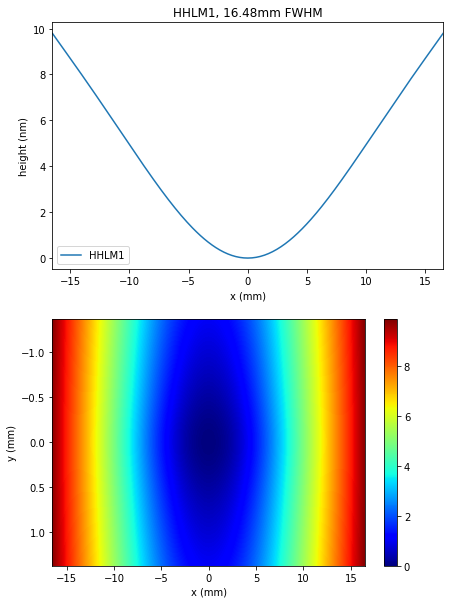

In [8]:
if_pad = 0

# directories
dir_profile = '../DXS_Xtals_FEA4WFS_3x/n_fwhm_2/{}/'.format(HHLM_type)

# holders
shapeErrors = [None for i in range(n_crys)]
x_mirs      = [None for i in range(n_crys)]
y_mirs      = [None for i in range(n_crys)]

# load
for i, crystal in enumerate(crystals):
    if crystal_powers[i] == 0: continue
    # load profiles from file
    dy, xx, zz = load_crystal_data(dir_profile, crystal, options[i])
    # proportionality constant due to power and crystal dimension
    height_factor1 = crystal_powers[i] / crystal_profile_powers[options[i]-1, i]    
    height_factor2 = (l_crystal[i]*1e3/(xx.max()-xx.min()))*(w_crystal[i]*1e3/(zz.max()-zz.min()))
    shapeErrors[i] = dy*1e6 * height_factor1 / height_factor2    # [nm]
    nx, ny = shapeErrors[i].shape; end_val = shapeErrors[i].max()
    if if_pad == 1:
        # stretch in both directions
        shapeErrors[i] = np.pad(shapeErrors[i],
                                pad_width=((nx,nx),(ny,ny)), mode='linear_ramp',
                                end_values = ((end_val,end_val),(end_val,end_val)))
        # modify dimensions for the new profile
        l_crystal[i] *= 3; w_crystal[i] *= 3
        # new crytal axis
        x_mirs[i] = np.linspace(-l_crystal[i]/2, l_crystal[i]/2, ny*3)
        y_mirs[i] = np.linspace(-w_crystal[i]/2, w_crystal[i]/2, nx*3)
    else:
        x_mirs[i] = np.linspace(-l_crystal[i]/2, l_crystal[i]/2, ny)
        y_mirs[i] = np.linspace(-w_crystal[i]/2, w_crystal[i]/2, nx)


# plot
n_subplot = np.sum(crystal_powers!=0)
plt.figure(figsize=(n_subplot*5+2, 10))
i_plot = 0
for i in range(n_crys):
    if crystal_powers[i] == 0: continue
    
    beam_projected_size = np.divide(beam_size, np.sin(beta0s))[i]*1e3   
    i_plot += 1
    plt.subplot(2, n_subplot, i_plot)
    plt.plot(x_mirs[i]*1e3, shapeErrors[i][1024,:], label=crystals[i])
    plt.legend(); plt.xlabel('x (mm)'); plt.ylabel('height (nm)')
    plt.title('{}, {}mm FWHM'.format(crystals[i], round(beam_projected_size,2)))
    plt.xlim([-beam_projected_size, beam_projected_size])
    plt.subplot(2, n_subplot, i_plot+n_subplot)
    plt.imshow(shapeErrors[i], cmap='jet',
              extent = [x_mirs[i].min()*1e3, x_mirs[i].max()*1e3, y_mirs[i].max()*1e3, y_mirs[i].min()*1e3])
    plt.colorbar(); plt.xlabel('x (mm)'); plt.ylabel('y (mm)'); plt.axis('tight')
    
    plt.xlim([-beam_projected_size, beam_projected_size])
    plt.clim([clim_list[i][0],clim_list[i][1]])
    
plt.savefig(dir_plot+'Comp_3x_'+fname_error+'.png')

print(zz.min()*1e3, xx.min()*1e3)